In [1]:
import pickle
import numpy as np
import spacy
import pandas as pd
from tqdm import tqdm
import re
import random
import gensim
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
import torch.optim as optim
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
from transformers import *
import math
import os
import copy
from model import *
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]= "1"
pd.options.display.max_rows = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

I0812 14:29:20.336745 139756668888896 file_utils.py:35] PyTorch version 1.6.0+cu92 available.


# Read data

In [2]:
total_data = pd.read_csv('consistent.csv')

# Prepare Training data

In [3]:
total_data['prop_value'] = total_data['prop_value'].apply(lambda x : x.lower())
# 建立字典和分詞
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenize_concat_sentence_list = []

for index, row in total_data.iterrows():
    wiki_value = row['prop_value']
    change_sentence = row['change_sentence']
    
    concat_sentence = []
    concat_sentence.append(tokenizer.encode(['[CLS]'], add_special_tokens=False)[0])
    wiki_value = tokenizer.encode(wiki_value, add_special_tokens=False)
    change_sentence = tokenizer.encode(change_sentence, add_special_tokens=False)
    change_sentence = change_sentence[:300]
    for index in wiki_value:
        concat_sentence.append(index)
    concat_sentence.append(tokenizer.encode(['[SEP]'], add_special_tokens=False)[0])
    for index in change_sentence:
        concat_sentence.append(index)
    
    concat_sentence.append(tokenizer.encode(['[SEP]'], add_special_tokens=False)[0])
    
    tokenize_concat_sentence_list.append(torch.tensor(concat_sentence).cuda())
    
    
train_concat_sentence, test_concat_sentence, y_train, y_test, train_index, test_index = train_test_split(tokenize_concat_sentence_list, total_data['label'], 
                                                                                                   total_data.index, test_size=0.2, random_state=42)
train_concat_sentence, valid_concat_sentence, y_train, y_valid, train_index, valid_index = train_test_split(train_concat_sentence, y_train, train_index, test_size=0.25, random_state=42)

train_concat_sentence = pad_sequence(train_concat_sentence, batch_first=True)
y_train = torch.tensor(y_train.values).cuda()

valid_concat_sentence = pad_sequence(valid_concat_sentence, batch_first=True)
y_valid = torch.tensor(y_valid.values).cuda()

test_concat_sentence = pad_sequence(test_concat_sentence, batch_first=True)
y_test = torch.tensor(y_test.values).cuda()

train_dataset = Data.TensorDataset(train_concat_sentence, y_train)
valid_dataset = Data.TensorDataset(valid_concat_sentence, y_valid)
test_dataset = Data.TensorDataset(test_concat_sentence, y_test)

train_dataloader = Data.DataLoader(train_dataset, batch_size=32)
valid_dataloader = Data.DataLoader(valid_dataset, batch_size=32)
test_dataloader = Data.DataLoader(test_dataset, batch_size=32)

I0812 14:29:22.342936 139756668888896 tokenization_utils.py:398] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/champion/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
W0812 14:29:29.945687 139756668888896 tokenization_utils.py:1084] Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors
W0812 14:29:30.005872 139756668888896 tokenization_utils.py:1084] Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors
W0812 14:29:34.357061 139756668888896 tokenization_utils.py:1084] Token indices sequence length is longer than the specified maximum sequence length for this mod

# Fintuning BERT

In [6]:
# load bert model 
# bert-base-uncased : use English corpus pretrain
model = BertForSequenceClassification.from_pretrained('bert-base-uncased').cuda()
optimizer = optim.Adam(model.parameters(), lr=5e-6, eps=1e-8)
CE = nn.CrossEntropyLoss()
epochs = 20

valid_accuracy_list = []
stopping_round = 0
for epoch in tqdm(range(epochs)):
    save_finetune_model_name = 'bert_finetune_model'
    CE_mean_loss = []
    train_predict_result = []
    valid_predict_result = []
    model.train()
    for train_concat_sentence_batch, y_train_batch in train_dataloader:
        output = model(train_concat_sentence_batch)[0]
        softmax = nn.Softmax(dim=1)
        train_pred_prob = softmax(output)
        train_pred_result = np.argmax(train_pred_prob.cpu().detach().numpy(), axis=1)
        for result in train_pred_result:
            train_predict_result.append(result)

        CE_loss = CE(output, y_train_batch)
        CE_mean_loss.append(CE_loss.cpu().detach().numpy())

        CE_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    for valid_concat_sentence_batch , y_valid_batch in valid_dataloader:
        output = model(valid_concat_sentence_batch)[0]
        softmax = nn.Softmax(dim=1)
        valid_pred_prob = softmax(output)
        valid_pred_result = np.argmax(valid_pred_prob.cpu().detach().numpy(), axis=1)
        for result in valid_pred_result:
            valid_predict_result.append(result)
        
    CE_mean_loss = np.mean(CE_mean_loss) 
    train_accuracy = accuracy_score(y_train.cpu(), train_predict_result)
    valid_accuracy = accuracy_score(y_valid.cpu(), valid_predict_result)
        
    # early stopping
    valid_accuracy_list.append(valid_accuracy)
    flag = False
    if epoch == 0:
        pass
    else:
        if valid_accuracy < valid_accuracy_list[epoch-1]:
            stopping_round += 1
        else:
            stopping_round -= 1
    if stopping_round == 3:
        print('Epochs:{},CE Loss:{:5f} train accuracy:{:5f} valid accuracy:{:5f}'.format(epoch,CE_mean_loss, train_accuracy, valid_accuracy))
        model_save_path = '/home/champion/wiki/finetuned_model/bert_en'.format(epoch)
        if not os.path.isdir(model_save_path):
            os.mkdir(model_save_path)
        model_structure_path = os.path.join(model_save_path, save_finetune_model_name)
        torch.save(model.state_dict(), model_structure_path)
        break

    print('Epochs:{},CE Loss:{:5f} train accuracy:{:5f} valid accuracy:{:5f}'.format(epoch,CE_mean_loss, train_accuracy, valid_accuracy))
    model_save_path = '/home/champion/wiki/finetuned_model/bert_en'.format(epoch)
    if not os.path.isdir(model_save_path):
        os.mkdir(model_save_path)
    model_structure_path = os.path.join(model_save_path, save_finetune_model_name)
    torch.save(model.state_dict(), model_structure_path)

  0%|          | 0/20 [00:00<?, ?it/s]

Epochs:0,CE Loss:0.696039 train accuracy:0.501862 valid accuracy:0.491838


  5%|▌         | 1/20 [02:34<49:01, 154.83s/it]

Epochs:1,CE Loss:0.313723 train accuracy:0.876253 valid accuracy:0.936856


 10%|█         | 2/20 [05:08<46:20, 154.47s/it]

Epochs:2,CE Loss:0.146290 train accuracy:0.958035 valid accuracy:0.958763


 15%|█▌        | 3/20 [07:40<43:36, 153.89s/it]

Epochs:3,CE Loss:0.117708 train accuracy:0.964337 valid accuracy:0.956186


 20%|██        | 4/20 [10:13<40:54, 153.41s/it]

Epochs:4,CE Loss:0.099761 train accuracy:0.968634 valid accuracy:0.960481


 25%|██▌       | 5/20 [12:45<38:15, 153.04s/it]

Epochs:5,CE Loss:0.083527 train accuracy:0.974219 valid accuracy:0.969931


 30%|███       | 6/20 [15:18<35:41, 152.95s/it]

Epochs:6,CE Loss:0.072830 train accuracy:0.975508 valid accuracy:0.965636


 35%|███▌      | 7/20 [17:50<33:06, 152.83s/it]

Epochs:7,CE Loss:0.055479 train accuracy:0.982383 valid accuracy:0.971649


 40%|████      | 8/20 [20:23<30:32, 152.70s/it]

Epochs:8,CE Loss:0.043918 train accuracy:0.984961 valid accuracy:0.971220


 45%|████▌     | 9/20 [22:55<27:59, 152.67s/it]

Epochs:9,CE Loss:0.035534 train accuracy:0.988685 valid accuracy:0.975945


 50%|█████     | 10/20 [25:28<25:26, 152.67s/it]

Epochs:10,CE Loss:0.031770 train accuracy:0.990261 valid accuracy:0.976375


 55%|█████▌    | 11/20 [28:00<22:53, 152.62s/it]

Epochs:11,CE Loss:0.024542 train accuracy:0.991979 valid accuracy:0.975086


 60%|██████    | 12/20 [30:33<20:19, 152.48s/it]

Epochs:12,CE Loss:0.024999 train accuracy:0.992552 valid accuracy:0.972938


 65%|██████▌   | 13/20 [33:04<17:45, 152.21s/it]

Epochs:13,CE Loss:0.019484 train accuracy:0.994128 valid accuracy:0.974656


 70%|███████   | 14/20 [35:36<15:12, 152.04s/it]

Epochs:14,CE Loss:0.015788 train accuracy:0.995274 valid accuracy:0.974227


 75%|███████▌  | 15/20 [38:07<12:39, 151.90s/it]

Epochs:15,CE Loss:0.016715 train accuracy:0.994128 valid accuracy:0.966065


 80%|████████  | 16/20 [40:39<10:07, 151.82s/it]

Epochs:16,CE Loss:0.014409 train accuracy:0.996133 valid accuracy:0.974656


 85%|████████▌ | 17/20 [43:11<07:35, 151.74s/it]

Epochs:17,CE Loss:0.013178 train accuracy:0.996706 valid accuracy:0.976804


 90%|█████████ | 18/20 [45:42<05:03, 151.69s/it]

Epochs:18,CE Loss:0.010314 train accuracy:0.997279 valid accuracy:0.971649


 95%|█████████▌| 19/20 [48:14<02:31, 151.66s/it]

Epochs:19,CE Loss:0.014498 train accuracy:0.995990 valid accuracy:0.971220


100%|██████████| 20/20 [50:45<00:00, 152.29s/it]


# Testing

In [4]:
all_finetuned_model_path = '/home/champion/wiki/finetuned_model/bert_en/bert_finetune_model'

model = BertForSequenceClassification.from_pretrained('bert-base-uncased').cuda()
pretrain_weight = torch.load(all_finetuned_model_path, map_location=device)
model.load_state_dict(pretrain_weight,strict=False)

test_predict_result = []
test_predict_prob = []
model.eval()
for test_concat_sentence_batch, y_test_batch in test_dataloader:
    output = model(test_concat_sentence_batch)[0]
    softmax = nn.Softmax(dim=1)
    test_pred_prob = softmax(output)
    test_pred_result = np.argmax(test_pred_prob.cpu().detach().numpy(), axis=1)
    test_pred_prob = torch.max(test_pred_prob, axis=1).values.cpu().detach().numpy()
    for result in test_pred_result:
        test_predict_result.append(result)
    for prob in test_pred_prob:
        test_predict_prob.append(prob)
test_predict_result = np.array(test_predict_result)

I0812 14:29:35.780840 139756668888896 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/champion/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I0812 14:29:35.781648 139756668888896 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_at

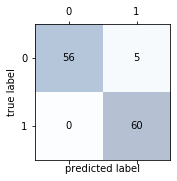

Accuracy: 0.9586776859504132
fpr: 0.08196721311475409
tpr: 1.0
rec: 0.9230769230769231
pre: 1.0
f1_score: 0.9600000000000001


In [5]:
prop = pd.DataFrame({'True':y_test.cpu().numpy(),'Pred':test_predict_result, 'Pred_prob':test_predict_prob,
                     'prop_label':total_data.iloc[test_index]['prop_label']})
io = prop.loc[prop['prop_label']=='Patientplus ID']


confmat = confusion_matrix(y_true = io['True'],y_pred=io['Pred'])
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

acc = (confmat[0,0] + confmat[1,1]) / (confmat[0,0] + confmat[0,1] + confmat[1,0] + confmat[1,1])
fpr = (confmat[0,1]) / (confmat[0,0] + confmat[0,1])
tpr = (confmat[1,1]) / (confmat[1,0] + confmat[1,1])
rec = (confmat[1,1] ) / (confmat[1,0] + confmat[1,1])
pre = (confmat[1,1]) / (confmat[0,1] + confmat[1,1])
f1_score = (2*pre*rec) / (pre + rec)
print('Accuracy:',acc)
print('fpr:',fpr)
print('tpr:',tpr)
print('rec:',pre)
print('pre:',rec)
print('f1_score:',f1_score)